In [2]:
import pandas as pd
import seaborn as sns


In [3]:
crashes_url = 'https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=download'
df_crashes= pd.read_csv(crashes_url, low_memory= False)


In [4]:
persons_url = 'https://data.cityofnewyork.us/api/views/f55k-p6yu/rows.csv?accessType=download'
df_persons = pd.read_csv(persons_url, low_memory = False)


In [5]:
df_crashes.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,11/01/2023,1:29,BROOKLYN,11230,40.62179,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,...,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN
3,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
4,09/21/2022,13:21,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


In [6]:
#EDA on df_crashes

print(df_crashes.shape)

(2221559, 29)


In [7]:
print(df_crashes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221559 entries, 0 to 2221558
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   LOCATION                       object 
 7   ON STREET NAME                 object 
 8   CROSS STREET NAME              object 
 9   OFF STREET NAME                object 
 10  NUMBER OF PERSONS INJURED      float64
 11  NUMBER OF PERSONS KILLED       float64
 12  NUMBER OF PEDESTRIANS INJURED  int64  
 13  NUMBER OF PEDESTRIANS KILLED   int64  
 14  NUMBER OF CYCLIST INJURED      int64  
 15  NUMBER OF CYCLIST KILLED       int64  
 16  NUMBER OF MOTORIST INJURED     int64  
 17  NUMBER OF MOTORIST KILLED      int64  
 18  CO

In [8]:
print(df_crashes.describe(include='all'))

        CRASH DATE CRASH TIME   BOROUGH ZIP CODE      LATITUDE     LONGITUDE  \
count      2221559    2221559   1541066  1540789  1.981191e+06  1.981191e+06   
unique        4887       1440         5      235           NaN           NaN   
top     01/21/2014      16:00  BROOKLYN    11207           NaN           NaN   
freq          1161      29707    493922    30446           NaN           NaN   
mean           NaN        NaN       NaN      NaN  4.058943e+01 -7.368250e+01   
std            NaN        NaN       NaN      NaN  2.337448e+00  4.344364e+00   
min            NaN        NaN       NaN      NaN  0.000000e+00 -2.013600e+02   
25%            NaN        NaN       NaN      NaN  4.066734e+01 -7.397453e+01   
50%            NaN        NaN       NaN      NaN  4.072031e+01 -7.392673e+01   
75%            NaN        NaN       NaN      NaN  4.076956e+01 -7.386657e+01   
max            NaN        NaN       NaN      NaN  4.334444e+01  0.000000e+00   

          LOCATION                    O

In [9]:
print(df_crashes.isna().sum())

CRASH DATE                             0
CRASH TIME                             0
BOROUGH                           680493
ZIP CODE                          680770
LATITUDE                          240368
LONGITUDE                         240368
LOCATION                          240368
ON STREET NAME                    484016
CROSS STREET NAME                 848936
OFF STREET NAME                  1829917
NUMBER OF PERSONS INJURED             18
NUMBER OF PERSONS KILLED              31
NUMBER OF PEDESTRIANS INJURED          0
NUMBER OF PEDESTRIANS KILLED           0
NUMBER OF CYCLIST INJURED              0
NUMBER OF CYCLIST KILLED               0
NUMBER OF MOTORIST INJURED             0
NUMBER OF MOTORIST KILLED              0
CONTRIBUTING FACTOR VEHICLE 1       7849
CONTRIBUTING FACTOR VEHICLE 2     356763
CONTRIBUTING FACTOR VEHICLE 3    2060796
CONTRIBUTING FACTOR VEHICLE 4    2184860
CONTRIBUTING FACTOR VEHICLE 5    2211504
COLLISION_ID                           0
VEHICLE TYPE COD

In [10]:
for col in df_crashes.columns:
  print(f"Unique values in '{col}': ")
  print(df_crashes[col].nunique())
  print("-"*20)

Unique values in 'CRASH DATE': 
4887
--------------------
Unique values in 'CRASH TIME': 
1440
--------------------
Unique values in 'BOROUGH': 
5
--------------------
Unique values in 'ZIP CODE': 
235
--------------------
Unique values in 'LATITUDE': 
129735
--------------------
Unique values in 'LONGITUDE': 
100671
--------------------
Unique values in 'LOCATION': 
334278
--------------------
Unique values in 'ON STREET NAME': 
22727
--------------------
Unique values in 'CROSS STREET NAME': 
24829
--------------------
Unique values in 'OFF STREET NAME': 
259668
--------------------
Unique values in 'NUMBER OF PERSONS INJURED': 
32
--------------------
Unique values in 'NUMBER OF PERSONS KILLED': 
7
--------------------
Unique values in 'NUMBER OF PEDESTRIANS INJURED': 
14
--------------------
Unique values in 'NUMBER OF PEDESTRIANS KILLED': 
6
--------------------
Unique values in 'NUMBER OF CYCLIST INJURED': 
5
--------------------
Unique values in 'NUMBER OF CYCLIST KILLED': 
3
--

In [11]:

print((df_crashes == "?").sum())

CRASH DATE                       0
CRASH TIME                       0
BOROUGH                          0
ZIP CODE                         0
LATITUDE                         0
LONGITUDE                        0
LOCATION                         0
ON STREET NAME                   0
CROSS STREET NAME                0
OFF STREET NAME                  0
NUMBER OF PERSONS INJURED        0
NUMBER OF PERSONS KILLED         0
NUMBER OF PEDESTRIANS INJURED    0
NUMBER OF PEDESTRIANS KILLED     0
NUMBER OF CYCLIST INJURED        0
NUMBER OF CYCLIST KILLED         0
NUMBER OF MOTORIST INJURED       0
NUMBER OF MOTORIST KILLED        0
CONTRIBUTING FACTOR VEHICLE 1    0
CONTRIBUTING FACTOR VEHICLE 2    0
CONTRIBUTING FACTOR VEHICLE 3    0
CONTRIBUTING FACTOR VEHICLE 4    0
CONTRIBUTING FACTOR VEHICLE 5    0
COLLISION_ID                     0
VEHICLE TYPE CODE 1              0
VEHICLE TYPE CODE 2              0
VEHICLE TYPE CODE 3              0
VEHICLE TYPE CODE 4              0
VEHICLE TYPE CODE 5 

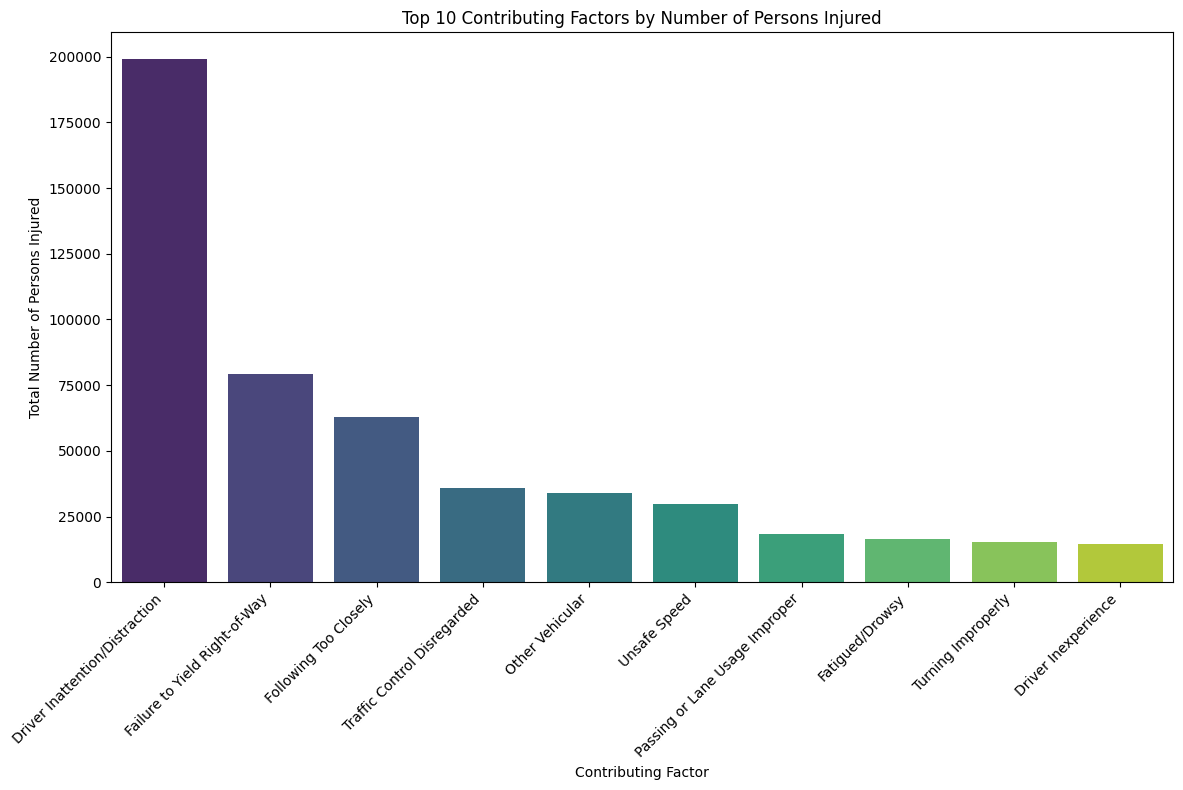

In [12]:
import matplotlib.pyplot as plt

# List of contributing factor columns
contributing_factor_cols = [
    'CONTRIBUTING FACTOR VEHICLE 1',
    'CONTRIBUTING FACTOR VEHICLE 2',
    'CONTRIBUTING FACTOR VEHICLE 3',
    'CONTRIBUTING FACTOR VEHICLE 4',
    'CONTRIBUTING FACTOR VEHICLE 5'
]

# Select relevant columns and fill NaN in 'NUMBER OF PERSONS INJURED' with 0
df_factors_injuries = df_crashes[contributing_factor_cols + ['NUMBER OF PERSONS INJURED']].copy()
df_factors_injuries['NUMBER OF PERSONS INJURED'] = df_factors_injuries['NUMBER OF PERSONS INJURED'].fillna(0)

# Melt the DataFrame to get all contributing factors in a single column
df_melted = df_factors_injuries.melt(id_vars=['NUMBER OF PERSONS INJURED'],
                                     value_vars=contributing_factor_cols,
                                     var_name='CONTRIBUTING_FACTOR_TYPE',
                                     value_name='CONTRIBUTING_FACTOR')

# Group by contributing factor and sum the number of injured persons
contributing_factors_summary = df_melted.groupby('CONTRIBUTING_FACTOR')['NUMBER OF PERSONS INJURED'].sum().sort_values(ascending=False)

# Exclude NaN and 'Unspecified' or 'N/A' if they appear as factors and take the top 10
top_10_factors = contributing_factors_summary[~contributing_factors_summary.index.isin(['Unspecified', 'NaN'])].head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_factors.index, y=top_10_factors.values, hue=top_10_factors.index, palette='viridis', legend=False)
plt.title('Top 10 Contributing Factors by Number of Persons Injured')
plt.xlabel('Contributing Factor')
plt.ylabel('Total Number of Persons Injured')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

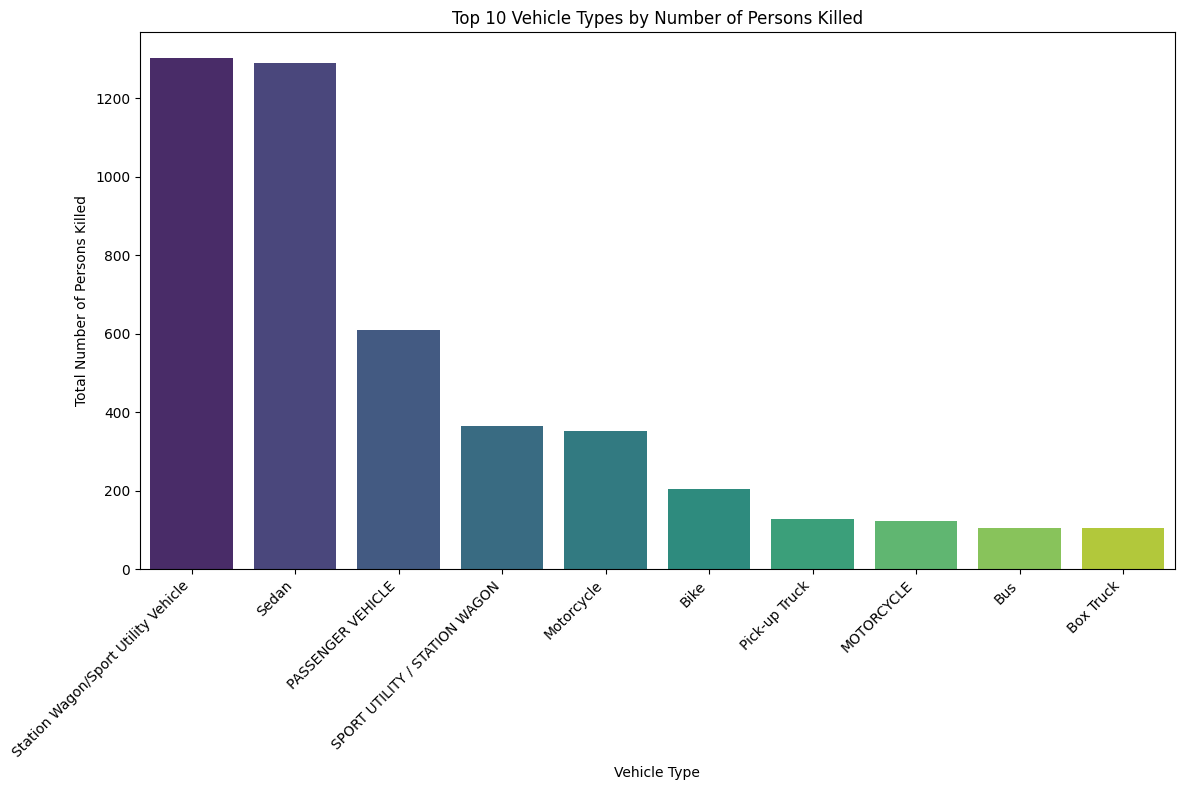

In [13]:
import matplotlib.pyplot as plt

# List of vehicle type columns
vehicle_type_cols = [
    'VEHICLE TYPE CODE 1',
    'VEHICLE TYPE CODE 2',
    'VEHICLE TYPE CODE 3',
    'VEHICLE TYPE CODE 4',
    'VEHICLE TYPE CODE 5'
]

# Select relevant columns and fill NaN in 'NUMBER OF PERSONS KILLED' with 0
df_vehicle_fatalities = df_crashes[vehicle_type_cols + ['NUMBER OF PERSONS KILLED']].copy()
df_vehicle_fatalities['NUMBER OF PERSONS KILLED'] = df_vehicle_fatalities['NUMBER OF PERSONS KILLED'].fillna(0)

# Melt the DataFrame to get all vehicle types in a single column
df_melted_vehicles = df_vehicle_fatalities.melt(id_vars=['NUMBER OF PERSONS KILLED'],
                                                value_vars=vehicle_type_cols,
                                                var_name='VEHICLE_TYPE_COLUMN',
                                                value_name='VEHICLE_TYPE')

# Group by vehicle type and sum the number of killed persons
vehicle_fatalities_summary = df_melted_vehicles.groupby('VEHICLE_TYPE')['NUMBER OF PERSONS KILLED'].sum().sort_values(ascending=False)

# Exclude NaN values and take the top 10
top_10_vehicle_types = vehicle_fatalities_summary[~vehicle_fatalities_summary.index.isna()].head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_vehicle_types.index, y=top_10_vehicle_types.values, hue=top_10_vehicle_types.index, palette='viridis', legend=False)
plt.title('Top 10 Vehicle Types by Number of Persons Killed')
plt.xlabel('Vehicle Type')
plt.ylabel('Total Number of Persons Killed')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

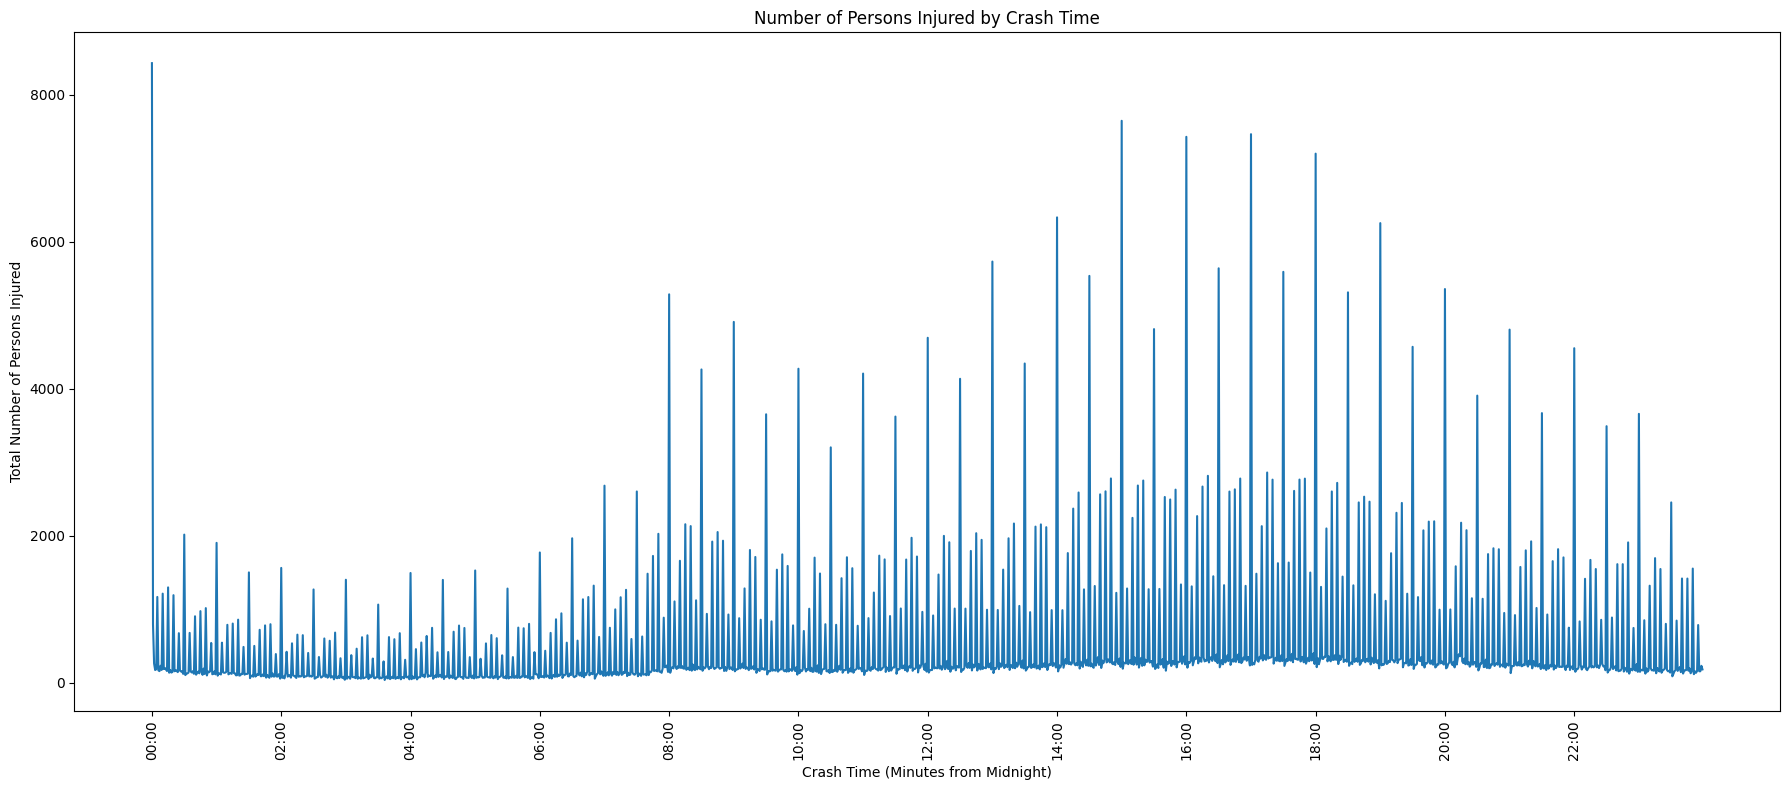

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fill NaN values in 'NUMBER OF PERSONS INJURED' with 0
df_crashes['NUMBER OF PERSONS INJURED'] = df_crashes['NUMBER OF PERSONS INJURED'].fillna(0)

# Group by 'CRASH TIME' and sum the number of injured persons
injuries_by_time = df_crashes.groupby('CRASH TIME')['NUMBER OF PERSONS INJURED'].sum().reset_index()

# Convert 'CRASH TIME' to datetime.time objects for proper sorting
injuries_by_time['CRASH TIME_OBJ'] = pd.to_datetime(injuries_by_time['CRASH TIME'], format='%H:%M').dt.time

# Sort by time
injuries_by_time = injuries_by_time.sort_values(by='CRASH TIME_OBJ')

# Convert time objects to minutes from midnight for plotting on a continuous axis
injuries_by_time['CRASH TIME_MINUTES'] = injuries_by_time['CRASH TIME_OBJ'].apply(lambda x: x.hour * 60 + x.minute)

# Create the plot
plt.figure(figsize=(18, 8))
sns.lineplot(x='CRASH TIME_MINUTES', y='NUMBER OF PERSONS INJURED', data=injuries_by_time)
plt.title('Number of Persons Injured by Crash Time')
plt.xlabel('Crash Time (Minutes from Midnight)')
plt.ylabel('Total Number of Persons Injured')

# Set x-axis ticks to show actual times at reasonable intervals
hour_intervals = range(0, 24 * 60, 60 * 2) # Every 2 hours
plt.xticks(ticks=hour_intervals, labels=[f'{h // 60:02d}:{(h % 60):02d}' for h in hour_intervals], rotation=90)

plt.tight_layout()
plt.show()

### Deep-Dive EDA: Borough, Temporal, and Spatial Signals
To satisfy the milestone requirement for richer exploratory analysis, the next few cells quantify how crash severity varies across boroughs, how overall crash volumes evolve over time, and how injury intensity changes throughout the day across boroughs.


Injury/fatality totals by borough (including Unknown records):
               NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED
BOROUGH                                                           
BROOKLYN                        173213.0                     722.0
QUEENS                          131555.0                     589.0
BRONX                            79270.0                     316.0
MANHATTAN                        77876.0                     383.0
STATEN ISLAND                    19428.0                     106.0


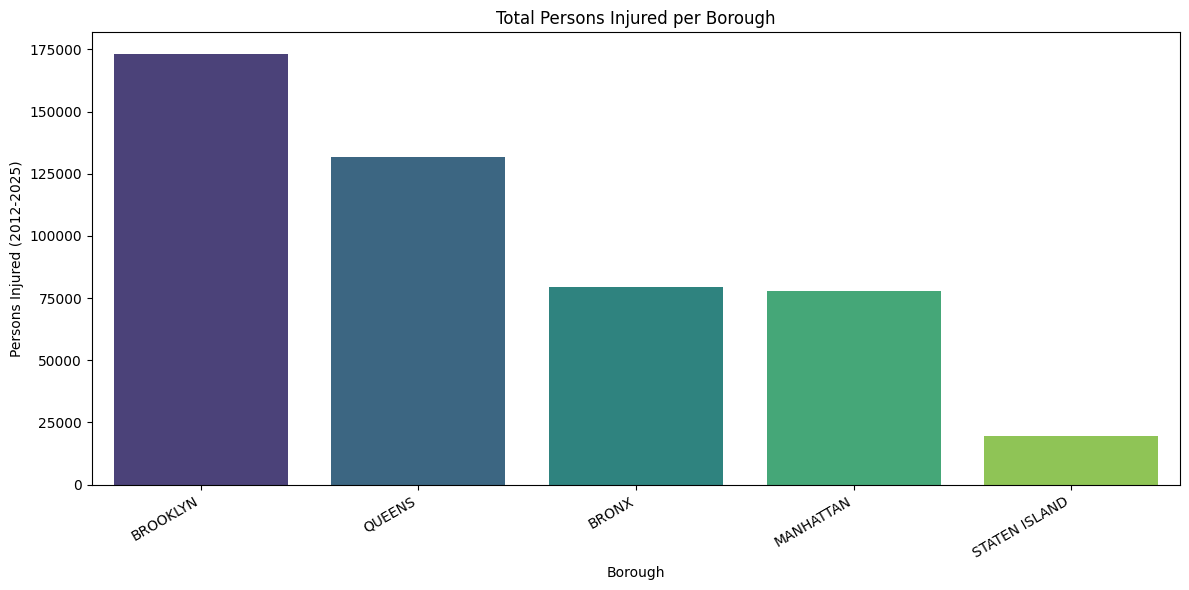

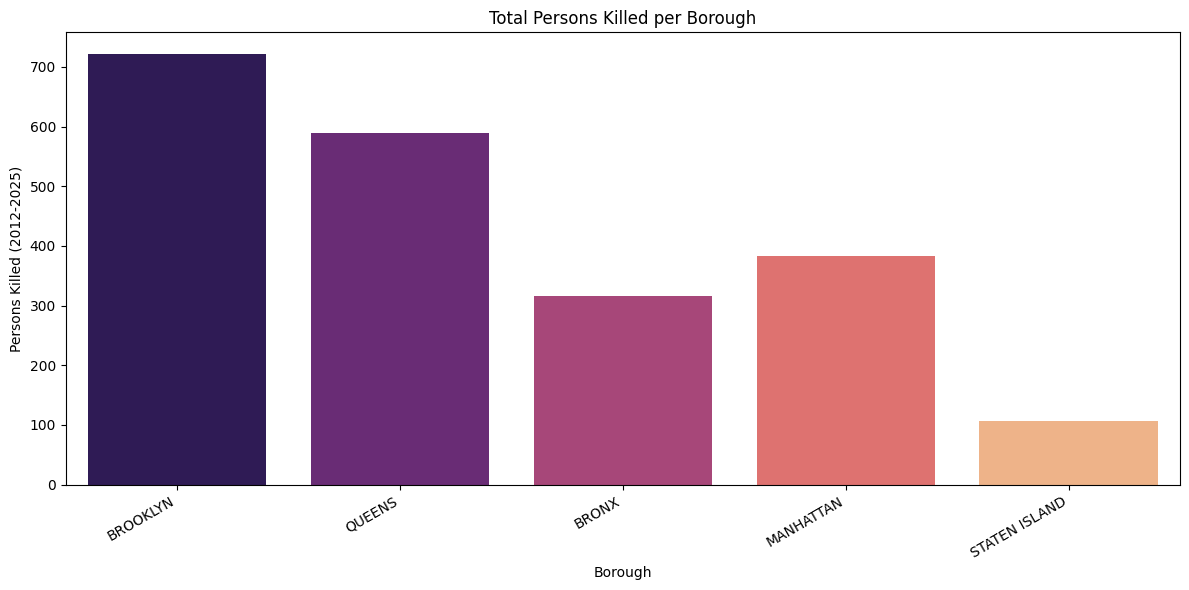

In [15]:
# Borough-level injuries and fatalities
borough_severity = (
    df_crashes.groupby('BOROUGH')[['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED']]
    .sum()
    .sort_values('NUMBER OF PERSONS INJURED', ascending=False)
)

print("Injury/fatality totals by borough (including Unknown records):")
print(borough_severity)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=borough_severity.reset_index(),
    x='BOROUGH',
    y='NUMBER OF PERSONS INJURED',
    hue='BOROUGH',
    legend=False,
    palette='viridis'
)
plt.title('Total Persons Injured per Borough')
plt.xlabel('Borough')
plt.ylabel('Persons Injured (2012-2025)')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=borough_severity.reset_index(),
    x='BOROUGH',
    y='NUMBER OF PERSONS KILLED',
    hue='BOROUGH',
    legend=False,
    palette='magma'
)
plt.title('Total Persons Killed per Borough')
plt.xlabel('Borough')
plt.ylabel('Persons Killed (2012-2025)')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


    CRASH_YEAR  CRASH_COUNT
9         2021       110557
10        2022       103887
11        2023        96606
12        2024        91313
13        2025        74351


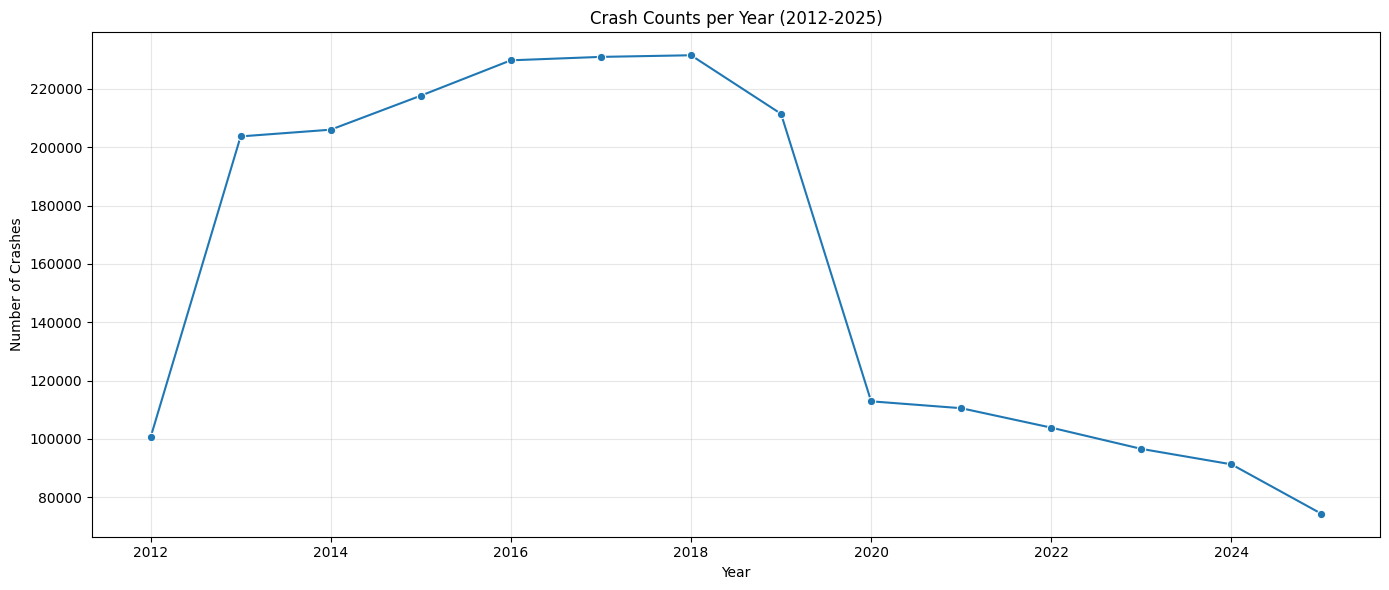

In [16]:
# Crash volume trend by year
crash_dates = pd.to_datetime(df_crashes['CRASH DATE'], errors='coerce')
df_crashes_yearly = (
    df_crashes.assign(CRASH_YEAR=crash_dates.dt.year)
    .dropna(subset=['CRASH_YEAR'])
)

crashes_per_year = (
    df_crashes_yearly.groupby('CRASH_YEAR')
    .size()
    .reset_index(name='CRASH_COUNT')
    .sort_values('CRASH_YEAR')
)

print(crashes_per_year.tail())

plt.figure(figsize=(14, 6))
sns.lineplot(data=crashes_per_year, x='CRASH_YEAR', y='CRASH_COUNT', marker='o')
plt.title('Crash Counts per Year (2012-2025)')
plt.xlabel('Year')
plt.ylabel('Number of Crashes')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


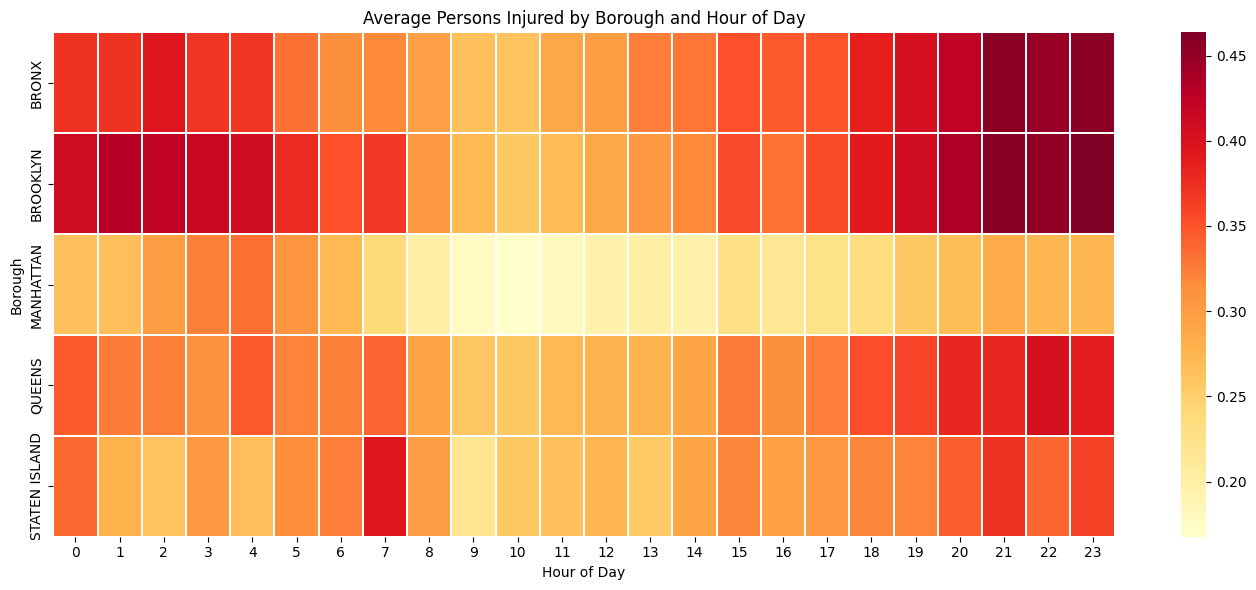

In [17]:
# Heatmap of injury intensity by borough and hour
crash_hours = pd.to_datetime(df_crashes['CRASH TIME'], format='%H:%M', errors='coerce').dt.hour

borough_hour_injuries = (
    df_crashes
    .assign(CRASH_HOUR=crash_hours)
    .dropna(subset=['CRASH_HOUR', 'BOROUGH'])
    .groupby(['BOROUGH', 'CRASH_HOUR'])['NUMBER OF PERSONS INJURED']
    .mean()
    .reset_index()
)

injury_heatmap = borough_hour_injuries.pivot(index='BOROUGH', columns='CRASH_HOUR', values='NUMBER OF PERSONS INJURED').fillna(0)

plt.figure(figsize=(14, 6))
sns.heatmap(injury_heatmap, cmap='YlOrRd', linewidths=0.3)
plt.title('Average Persons Injured by Borough and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Borough')
plt.tight_layout()
plt.show()


In [18]:

df_persons.head()

,UNIQUE_ID,COLLISION_ID,CRASH_DATE,CRASH_TIME,PERSON_ID,PERSON_TYPE,PERSON_INJURY,VEHICLE_ID,PERSON_AGE,EJECTION,...,BODILY_INJURY,POSITION_IN_VEHICLE,SAFETY_EQUIPMENT,PED_LOCATION,PED_ACTION,COMPLAINT,PED_ROLE,CONTRIBUTING_FACTOR_1,CONTRIBUTING_FACTOR_2,PERSON_SEX
0,10249006,4229554,10/26/2019,9:43,31aa2bc0-f545-444f-8cdb-f1cb5cf00b89,Occupant,Unspecified,19141108.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Registrant,NaN,NaN,U
1,10255054,4230587,10/25/2019,15:15,4629e500-a73e-48dc-b8fb-53124d124b80,Occupant,Unspecified,19144075.0,33.0,Not Ejected,...,Does Not Apply,"Front passenger, if two or more persons, inclu...",Lap Belt & Harness,NaN,NaN,Does Not Apply,Passenger,NaN,NaN,F
2,10253177,4230550,10/26/2019,17:55,ae48c136-1383-45db-83f4-2a5eecfb7cff,Occupant,Unspecified,19143133.0,55.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Registrant,NaN,NaN,M
3,6650180,3565527,11/21/2016,13:05,2782525,Occupant,Unspecified,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Notified Person,NaN,NaN,NaN
4,10255516,4231168,10/25/2019,11:16,e038e18f-40fb-4471-99cf-345eae36e064,Occupant,Unspecified,19144329.0,7.0,Not Ejected,...,Does Not Apply,Right rear passenger or motorcycle sidecar pas...,Lap Belt,NaN,NaN,Does Not Apply,Passenger,NaN,NaN,F


# **EDA for df_persons**

In [19]:
print(df_persons.shape)

(5823480, 21)


In [20]:
print(df_persons.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5823480 entries, 0 to 5823479
Data columns (total 21 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   UNIQUE_ID              int64  
 1   COLLISION_ID           int64  
 2   CRASH_DATE             object 
 3   CRASH_TIME             object 
 4   PERSON_ID              object 
 5   PERSON_TYPE            object 
 6   PERSON_INJURY          object 
 7   VEHICLE_ID             float64
 8   PERSON_AGE             float64
 9   EJECTION               object 
 10  EMOTIONAL_STATUS       object 
 11  BODILY_INJURY          object 
 12  POSITION_IN_VEHICLE    object 
 13  SAFETY_EQUIPMENT       object 
 14  PED_LOCATION           object 
 15  PED_ACTION             object 
 16  COMPLAINT              object 
 17  PED_ROLE               object 
 18  CONTRIBUTING_FACTOR_1  object 
 19  CONTRIBUTING_FACTOR_2  object 
 20  PERSON_SEX             object 
dtypes: float64(2), int64(2), object(17)
memory usage: 933.

In [21]:
print(df_persons.describe(include='all'))

           UNIQUE_ID  COLLISION_ID  CRASH_DATE CRASH_TIME PERSON_ID  \
count   5.823480e+06  5.823480e+06     5823480    5823480   5823461   
unique           NaN           NaN        4887       1440   5628657   
top              NaN           NaN  11/15/2018       0:00         1   
freq             NaN           NaN        4220      87489    142787   
mean    9.377248e+06  4.016751e+06         NaN        NaN       NaN   
std     2.763102e+06  6.650032e+05         NaN        NaN       NaN   
min     1.092200e+04  3.700000e+01         NaN        NaN       NaN   
25%     7.099515e+06  3.705605e+06         NaN        NaN       NaN   
50%     9.574750e+06  4.060852e+06         NaN        NaN       NaN   
75%     1.188696e+07  4.439741e+06         NaN        NaN       NaN   
max     1.353756e+07  4.858367e+06         NaN        NaN       NaN   

       PERSON_TYPE PERSON_INJURY    VEHICLE_ID    PERSON_AGE     EJECTION  \
count      5823480       5823480  5.581919e+06  5.172907e+06      2994

In [22]:
print(df_persons.isna().sum())

UNIQUE_ID                      0
COLLISION_ID                   0
CRASH_DATE                     0
CRASH_TIME                     0
PERSON_ID                     19
PERSON_TYPE                    0
PERSON_INJURY                  0
VEHICLE_ID                241561
PERSON_AGE                650573
EJECTION                 2829327
EMOTIONAL_STATUS         2732204
BODILY_INJURY            2732161
POSITION_IN_VEHICLE      2828870
SAFETY_EQUIPMENT         3032359
PED_LOCATION             5721005
PED_ACTION               5721106
COMPLAINT                2732154
PED_ROLE                  194889
CONTRIBUTING_FACTOR_1    5722385
CONTRIBUTING_FACTOR_2    5722518
PERSON_SEX                643831
dtype: int64


In [23]:
for col in df_persons.columns:
  print(f"Unique values in '{col}': ")
  print(df_persons[col].nunique())
  print("-" * 20)

Unique values in 'UNIQUE_ID': 
5823480
--------------------
Unique values in 'COLLISION_ID': 
1591547
--------------------
Unique values in 'CRASH_DATE': 
4887
--------------------
Unique values in 'CRASH_TIME': 
1440
--------------------
Unique values in 'PERSON_ID': 
5628657
--------------------
Unique values in 'PERSON_TYPE': 
4
--------------------
Unique values in 'PERSON_INJURY': 
3
--------------------
Unique values in 'VEHICLE_ID': 
2702201
--------------------
Unique values in 'PERSON_AGE': 
907
--------------------
Unique values in 'EJECTION': 
6
--------------------
Unique values in 'EMOTIONAL_STATUS': 
8
--------------------
Unique values in 'BODILY_INJURY': 
14
--------------------
Unique values in 'POSITION_IN_VEHICLE': 
11
--------------------
Unique values in 'SAFETY_EQUIPMENT': 
17
--------------------
Unique values in 'PED_LOCATION': 
4
--------------------
Unique values in 'PED_ACTION': 
16
--------------------
Unique values in 'COMPLAINT': 
21
--------------------
U

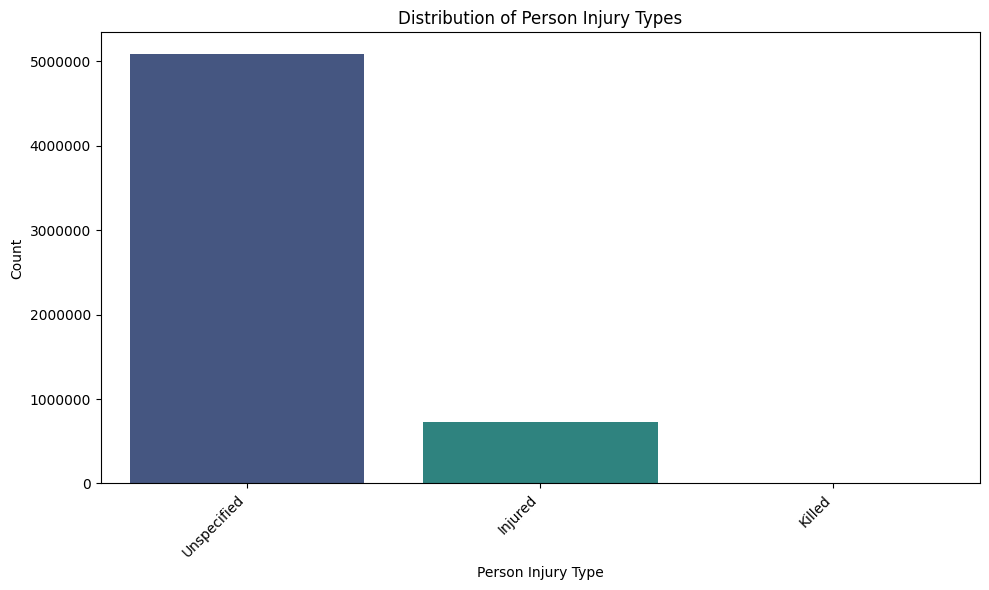

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each unique value in the 'PERSON_INJURY' column
injury_counts = df_persons['PERSON_INJURY'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=injury_counts.index, y=injury_counts.values, hue=injury_counts.index, palette='viridis', legend=False)
plt.title('Distribution of Person Injury Types')
plt.xlabel('Person Injury Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.ticklabel_format(style='plain', axis='y') # Ensure y-axis shows actual counts plainly
plt.tight_layout()
plt.show()

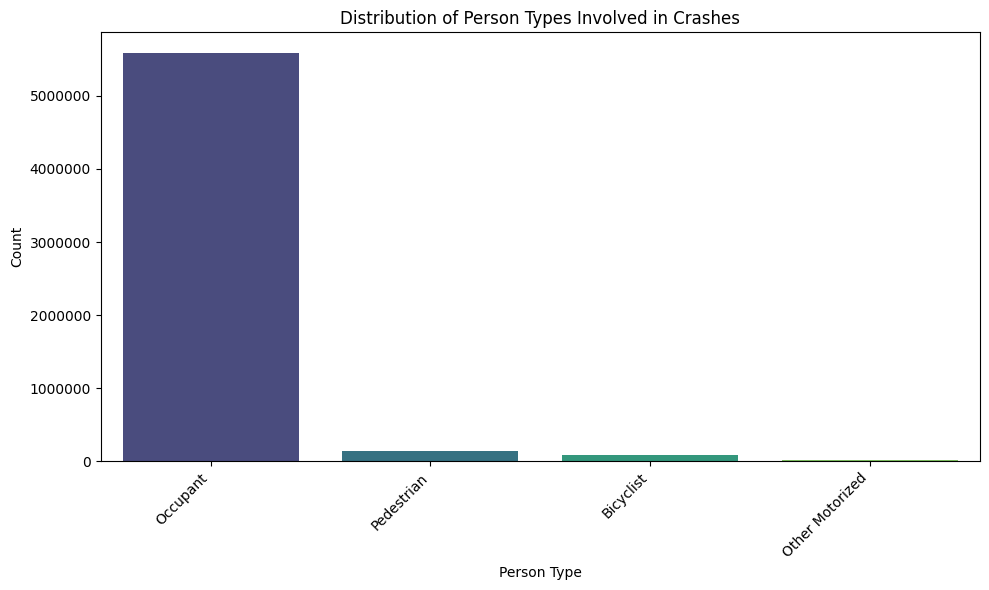

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each unique value in the 'PERSON_TYPE' column
person_type_counts = df_persons['PERSON_TYPE'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=person_type_counts.index, y=person_type_counts.values, hue=person_type_counts.index, palette='viridis', legend=False)
plt.title('Distribution of Person Types Involved in Crashes')
plt.xlabel('Person Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.ticklabel_format(style='plain', axis='y') # Ensure y-axis shows actual counts plainly
plt.tight_layout()
plt.show()

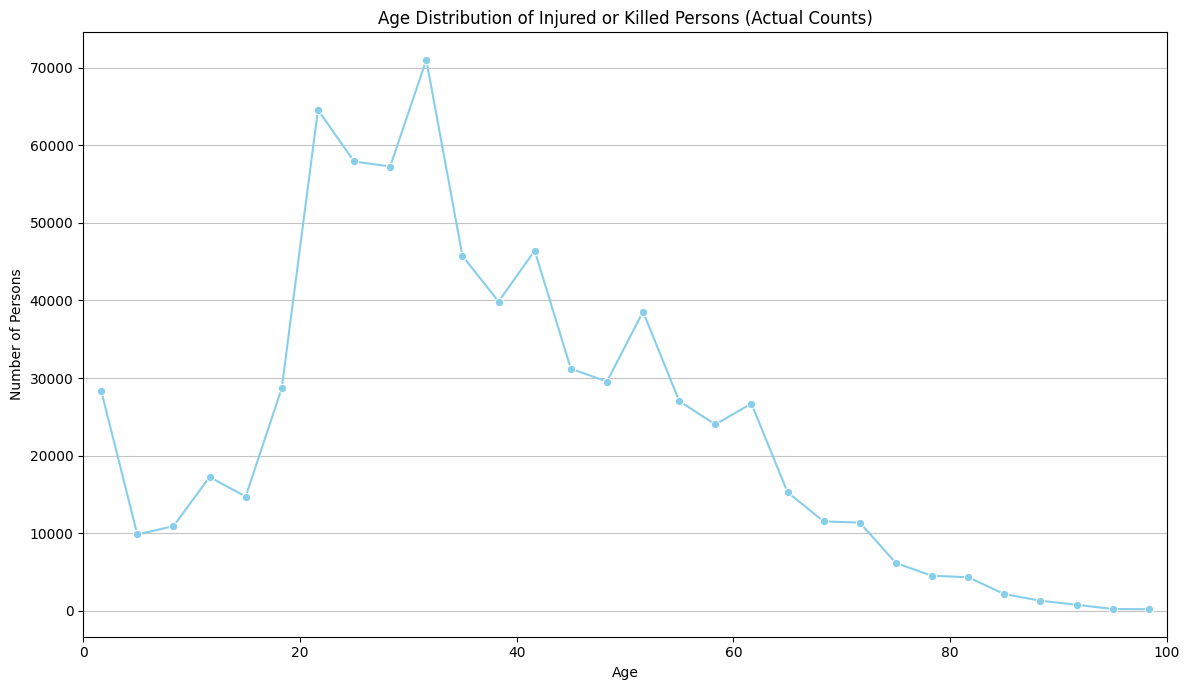

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter the DataFrame for persons who were either 'Injured' or 'Killed'
injured_killed_persons = df_persons[df_persons['PERSON_INJURY'].isin(['Injured', 'Killed'])].copy()

# Select the 'PERSON_AGE' column and filter out anomalous age entries (ages < 0)
filtered_ages = injured_killed_persons[injured_killed_persons['PERSON_AGE'] >= 0]['PERSON_AGE'].dropna()

# Define bins for age and calculate counts within each bin
# Using 30 bins over the 0-100 range, similar to the previous histplot
bins = np.linspace(0, 100, 31) # Create 30 bins for ages from 0 to 100
counts, bin_edges = np.histogram(filtered_ages, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Create a line plot of the binned counts
plt.figure(figsize=(12, 7))
sns.lineplot(x=bin_centers, y=counts, color='skyblue', marker='o', errorbar=None) # Added markers for clarity
plt.title('Age Distribution of Injured or Killed Persons (Actual Counts)')
plt.xlabel('Age')
plt.ylabel('Number of Persons')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0, 100) # Ensure x-axis limit remains 0 to 100
plt.tight_layout()
plt.show()

### ***Cleaning for df_crashes***

In [27]:
##combine the 'CRASH DATE' and 'CRASH TIME' columns into a single 'CRASH DATETIME' column

df_crashes['CRASH DATETIME'] = pd.to_datetime(df_crashes['CRASH DATE'] + ' ' + df_crashes['CRASH TIME'], format='%m/%d/%Y %H:%M')
df_crashes.drop(columns=['CRASH DATE', 'CRASH TIME'], inplace=True)
print(df_crashes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221559 entries, 0 to 2221558
Data columns (total 28 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   BOROUGH                        object        
 1   ZIP CODE                       object        
 2   LATITUDE                       float64       
 3   LONGITUDE                      float64       
 4   LOCATION                       object        
 5   ON STREET NAME                 object        
 6   CROSS STREET NAME              object        
 7   OFF STREET NAME                object        
 8   NUMBER OF PERSONS INJURED      float64       
 9   NUMBER OF PERSONS KILLED       float64       
 10  NUMBER OF PEDESTRIANS INJURED  int64         
 11  NUMBER OF PEDESTRIANS KILLED   int64         
 12  NUMBER OF CYCLIST INJURED      int64         
 13  NUMBER OF CYCLIST KILLED       int64         
 14  NUMBER OF MOTORIST INJURED     int64         
 15  NUMBER OF MOTOR

In [28]:
##Fill nulls of NUMBER OF PERSONS INJURED' and NUMBER OF PERSONS INJURED' with 0
##mean would not work because of the range of the values
df_crashes['NUMBER OF PERSONS INJURED'] = df_crashes['NUMBER OF PERSONS INJURED'].fillna(0).astype(int)
df_crashes['NUMBER OF PERSONS KILLED'] = df_crashes['NUMBER OF PERSONS KILLED'].fillna(0).astype(int)
print(df_crashes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221559 entries, 0 to 2221558
Data columns (total 28 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   BOROUGH                        object        
 1   ZIP CODE                       object        
 2   LATITUDE                       float64       
 3   LONGITUDE                      float64       
 4   LOCATION                       object        
 5   ON STREET NAME                 object        
 6   CROSS STREET NAME              object        
 7   OFF STREET NAME                object        
 8   NUMBER OF PERSONS INJURED      int64         
 9   NUMBER OF PERSONS KILLED       int64         
 10  NUMBER OF PEDESTRIANS INJURED  int64         
 11  NUMBER OF PEDESTRIANS KILLED   int64         
 12  NUMBER OF CYCLIST INJURED      int64         
 13  NUMBER OF CYCLIST KILLED       int64         
 14  NUMBER OF MOTORIST INJURED     int64         
 15  NUMBER OF MOTOR

In [29]:
##fill all catigorical values withh Unknown
categorical_cols_to_fill = [
    'BOROUGH', 'ZIP CODE', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME',
    'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
    'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
    'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3',
    'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'
]

for col in categorical_cols_to_fill:
    df_crashes[col] = df_crashes[col].fillna('Unknown')

print(df_crashes.info())
print(df_crashes[categorical_cols_to_fill].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221559 entries, 0 to 2221558
Data columns (total 28 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   BOROUGH                        object        
 1   ZIP CODE                       object        
 2   LATITUDE                       float64       
 3   LONGITUDE                      float64       
 4   LOCATION                       object        
 5   ON STREET NAME                 object        
 6   CROSS STREET NAME              object        
 7   OFF STREET NAME                object        
 8   NUMBER OF PERSONS INJURED      int64         
 9   NUMBER OF PERSONS KILLED       int64         
 10  NUMBER OF PEDESTRIANS INJURED  int64         
 11  NUMBER OF PEDESTRIANS KILLED   int64         
 12  NUMBER OF CYCLIST INJURED      int64         
 13  NUMBER OF CYCLIST KILLED       int64         
 14  NUMBER OF MOTORIST INJURED     int64         
 15  NUMBER OF MOTOR

In [30]:
##Fill missing values of latitude and longitude with 0

df_crashes['LATITUDE'] = df_crashes['LATITUDE'].fillna(0)
df_crashes['LONGITUDE'] = df_crashes['LONGITUDE'].fillna(0)
print(df_crashes.info())
print(df_crashes[['LATITUDE', 'LONGITUDE']].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221559 entries, 0 to 2221558
Data columns (total 28 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   BOROUGH                        object        
 1   ZIP CODE                       object        
 2   LATITUDE                       float64       
 3   LONGITUDE                      float64       
 4   LOCATION                       object        
 5   ON STREET NAME                 object        
 6   CROSS STREET NAME              object        
 7   OFF STREET NAME                object        
 8   NUMBER OF PERSONS INJURED      int64         
 9   NUMBER OF PERSONS KILLED       int64         
 10  NUMBER OF PEDESTRIANS INJURED  int64         
 11  NUMBER OF PEDESTRIANS KILLED   int64         
 12  NUMBER OF CYCLIST INJURED      int64         
 13  NUMBER OF CYCLIST KILLED       int64         
 14  NUMBER OF MOTORIST INJURED     int64         
 15  NUMBER OF MOTOR

# ***Cleaning for df_persons***

In [31]:
##also make crash date and crash time in one cell
df_persons['CRASH_DATETIME'] = pd.to_datetime(df_persons['CRASH_DATE'] + ' ' + df_persons['CRASH_TIME'], format='%m/%d/%Y %H:%M')
df_persons.drop(columns=['CRASH_DATE', 'CRASH_TIME'], inplace=True)
print(df_persons.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5823480 entries, 0 to 5823479
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   UNIQUE_ID              int64         
 1   COLLISION_ID           int64         
 2   PERSON_ID              object        
 3   PERSON_TYPE            object        
 4   PERSON_INJURY          object        
 5   VEHICLE_ID             float64       
 6   PERSON_AGE             float64       
 7   EJECTION               object        
 8   EMOTIONAL_STATUS       object        
 9   BODILY_INJURY          object        
 10  POSITION_IN_VEHICLE    object        
 11  SAFETY_EQUIPMENT       object        
 12  PED_LOCATION           object        
 13  PED_ACTION             object        
 14  COMPLAINT              object        
 15  PED_ROLE               object        
 16  CONTRIBUTING_FACTOR_1  object        
 17  CONTRIBUTING_FACTOR_2  object        
 18  PERSON_SEX            

In [32]:
##Fix outliers in age cell
import numpy as np
df_persons['PERSON_AGE'] = df_persons['PERSON_AGE'].replace(-999, np.nan).astype(float)
print(df_persons.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5823480 entries, 0 to 5823479
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   UNIQUE_ID              int64         
 1   COLLISION_ID           int64         
 2   PERSON_ID              object        
 3   PERSON_TYPE            object        
 4   PERSON_INJURY          object        
 5   VEHICLE_ID             float64       
 6   PERSON_AGE             float64       
 7   EJECTION               object        
 8   EMOTIONAL_STATUS       object        
 9   BODILY_INJURY          object        
 10  POSITION_IN_VEHICLE    object        
 11  SAFETY_EQUIPMENT       object        
 12  PED_LOCATION           object        
 13  PED_ACTION             object        
 14  COMPLAINT              object        
 15  PED_ROLE               object        
 16  CONTRIBUTING_FACTOR_1  object        
 17  CONTRIBUTING_FACTOR_2  object        
 18  PERSON_SEX            

In [33]:
##also fill null values in catigorical columns with unknown
categorical_cols_to_fill_persons = [
    'EJECTION', 'EMOTIONAL_STATUS', 'BODILY_INJURY', 'POSITION_IN_VEHICLE',
    'SAFETY_EQUIPMENT', 'PED_LOCATION', 'PED_ACTION', 'COMPLAINT', 'PED_ROLE',
    'CONTRIBUTING_FACTOR_1', 'CONTRIBUTING_FACTOR_2', 'PERSON_SEX'
]

for col in categorical_cols_to_fill_persons:
    df_persons[col] = df_persons[col].fillna('Unknown')

print(df_persons.info())
print(df_persons[categorical_cols_to_fill_persons].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5823480 entries, 0 to 5823479
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   UNIQUE_ID              int64         
 1   COLLISION_ID           int64         
 2   PERSON_ID              object        
 3   PERSON_TYPE            object        
 4   PERSON_INJURY          object        
 5   VEHICLE_ID             float64       
 6   PERSON_AGE             float64       
 7   EJECTION               object        
 8   EMOTIONAL_STATUS       object        
 9   BODILY_INJURY          object        
 10  POSITION_IN_VEHICLE    object        
 11  SAFETY_EQUIPMENT       object        
 12  PED_LOCATION           object        
 13  PED_ACTION             object        
 14  COMPLAINT              object        
 15  PED_ROLE               object        
 16  CONTRIBUTING_FACTOR_1  object        
 17  CONTRIBUTING_FACTOR_2  object        
 18  PERSON_SEX            

In [34]:
##fill missing values in personId and vehicleID with unknown
df_persons['PERSON_ID'] = df_persons['PERSON_ID'].fillna('Unknown')
df_persons['VEHICLE_ID'] = df_persons['VEHICLE_ID'].fillna('Unknown')

print(df_persons.info())
print(df_persons[['PERSON_ID', 'VEHICLE_ID']].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5823480 entries, 0 to 5823479
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   UNIQUE_ID              int64         
 1   COLLISION_ID           int64         
 2   PERSON_ID              object        
 3   PERSON_TYPE            object        
 4   PERSON_INJURY          object        
 5   VEHICLE_ID             object        
 6   PERSON_AGE             float64       
 7   EJECTION               object        
 8   EMOTIONAL_STATUS       object        
 9   BODILY_INJURY          object        
 10  POSITION_IN_VEHICLE    object        
 11  SAFETY_EQUIPMENT       object        
 12  PED_LOCATION           object        
 13  PED_ACTION             object        
 14  COMPLAINT              object        
 15  PED_ROLE               object        
 16  CONTRIBUTING_FACTOR_1  object        
 17  CONTRIBUTING_FACTOR_2  object        
 18  PERSON_SEX            

# **Check for outliers**

### Outlier Remediation Strategy
Using the 1.5×IQR thresholds we just profiled, the following cell caps injury/fatality counts to the upper whisker bounds and enforces realistic age ranges in the persons table. This preserves distributional shape while preventing extreme values from skewing aggregates and plots.


In [35]:
# Apply IQR capping to crash injury/fatality counts and clean person ages
def cap_outliers_iqr(df, columns):
    adjustments = []
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = max(q1 - 1.5 * iqr, 0)
        upper = q3 + 1.5 * iqr
        before = df[col].copy()
        df[col] = df[col].clip(lower=lower, upper=upper).round().astype(int)
        changed = (before != df[col]).sum()
        adjustments.append({'column': col, 'adjusted_rows': int(changed), 'upper_cap': upper})
    return pd.DataFrame(adjustments)

injury_cols = [
    'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
    'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
    'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
    'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED'
]

injury_adjustments_summary = cap_outliers_iqr(df_crashes, injury_cols)
print("Rows adjusted per injury/fatality column:")
print(injury_adjustments_summary)

# Cap person ages to the 1st-99th percentile range after removing negatives
age_lower = 0
age_upper = df_persons['PERSON_AGE'].quantile(0.99)
before_age = df_persons['PERSON_AGE'].copy()
df_persons['PERSON_AGE'] = df_persons['PERSON_AGE'].clip(lower=age_lower, upper=age_upper)
age_changes = (before_age != df_persons['PERSON_AGE']).sum()
print(f"Person ages clipped outside [{age_lower}, {age_upper:.1f}] for {int(age_changes)} rows")


Rows adjusted per injury/fatality column:
                          column  adjusted_rows  upper_cap
0      NUMBER OF PERSONS INJURED         538577        0.0
1       NUMBER OF PERSONS KILLED           3373        0.0
2  NUMBER OF PEDESTRIANS INJURED         127027        0.0
3   NUMBER OF PEDESTRIANS KILLED           1716        0.0
4      NUMBER OF CYCLIST INJURED          64056        0.0
5       NUMBER OF CYCLIST KILLED            279        0.0
6     NUMBER OF MOTORIST INJURED         341207        0.0
7      NUMBER OF MOTORIST KILLED           1322        0.0
Person ages clipped outside [0, 80.0] for 698199 rows


In [36]:
import numpy as np

numerical_cols = df_crashes.select_dtypes(include=['int64', 'float64']).columns

outlier_counts = {}

for col in numerical_cols:
    Q1 = df_crashes[col].quantile(0.25)
    Q3 = df_crashes[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    num_outliers = df_crashes[(df_crashes[col] < lower_bound) | (df_crashes[col] > upper_bound)].shape[0]
    outlier_counts[col] = num_outliers

print("Number of outliers in each numerical column (1.5*IQR rule):")
for col, count in outlier_counts.items():
    print(f"'{col}': {count}")

Number of outliers in each numerical column (1.5*IQR rule):
'LATITUDE': 246926
'LONGITUDE': 263266
'NUMBER OF PERSONS INJURED': 0
'NUMBER OF PERSONS KILLED': 0
'NUMBER OF PEDESTRIANS INJURED': 0
'NUMBER OF PEDESTRIANS KILLED': 0
'NUMBER OF CYCLIST INJURED': 0
'NUMBER OF CYCLIST KILLED': 0
'NUMBER OF MOTORIST INJURED': 0
'NUMBER OF MOTORIST KILLED': 0
'COLLISION_ID': 411741


In [37]:
import numpy as np

numerical_cols_persons = df_persons.select_dtypes(include=['int64', 'float64']).columns

outlier_counts_persons = {}

for col in numerical_cols_persons:
    Q1 = df_persons[col].quantile(0.25)
    Q3 = df_persons[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    num_outliers = df_persons[(df_persons[col] < lower_bound) | (df_persons[col] > upper_bound)].shape[0]
    outlier_counts_persons[col] = num_outliers

print("Number of outliers in each numerical column of df_persons (1.5*IQR rule):")
for col, count in outlier_counts_persons.items():
    print(f"'{col}': {count}")

Number of outliers in each numerical column of df_persons (1.5*IQR rule):
'UNIQUE_ID': 0
'COLLISION_ID': 107009
'PERSON_AGE': 0


### Duplicate Remediation
After quantifying duplicate `COLLISION_ID` counts, we explicitly drop any repeated crash, person, or integrated records to ensure downstream aggregations are not double-counted.


In [38]:
# Remove duplicate rows before integration
crashes_before = len(df_crashes)
df_crashes = df_crashes.drop_duplicates()
print(f"Dropped {crashes_before - len(df_crashes)} duplicate crash rows")

# UNIQUE_ID should already be unique, but we guard against accidental duplication
persons_before = len(df_persons)
df_persons = df_persons.drop_duplicates(subset=['UNIQUE_ID'])
print(f"Dropped {persons_before - len(df_persons)} duplicate person rows")

# Also ensure no duplicate COLLISION_ID + PERSON_ID combinations remain
persons_before_combo = len(df_persons)
df_persons = df_persons.drop_duplicates(subset=['COLLISION_ID', 'PERSON_ID', 'PERSON_TYPE', 'PERSON_INJURY'])
print(f"Dropped {persons_before_combo - len(df_persons)} duplicate person role rows")


Dropped 0 duplicate crash rows
Dropped 0 duplicate person rows
Dropped 0 duplicate person role rows


In [39]:
import numpy as np

numerical_cols_crashes = df_crashes.select_dtypes(include=['int64', 'float64']).columns

# Columns to exclude from outlier detection
excluded_cols = ['LATITUDE', 'LONGITUDE', 'COLLISION_ID']

# Filter numerical columns to exclude specified ones
filtered_numerical_cols_crashes = [col for col in numerical_cols_crashes if col not in excluded_cols]

outlier_counts_crashes_filtered = {}

for col in filtered_numerical_cols_crashes:
    Q1 = df_crashes[col].quantile(0.25)
    Q3 = df_crashes[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    num_outliers = df_crashes[(df_crashes[col] < lower_bound) | (df_crashes[col] > upper_bound)].shape[0]
    outlier_counts_crashes_filtered[col] = num_outliers

print("Number of outliers in df_crashes numerical columns (excluding LATITUDE, LONGITUDE, COLLISION_ID) (1.5*IQR rule):")
for col, count in outlier_counts_crashes_filtered.items():
    print(f"'{col}': {count}")

Number of outliers in df_crashes numerical columns (excluding LATITUDE, LONGITUDE, COLLISION_ID) (1.5*IQR rule):
'NUMBER OF PERSONS INJURED': 0
'NUMBER OF PERSONS KILLED': 0
'NUMBER OF PEDESTRIANS INJURED': 0
'NUMBER OF PEDESTRIANS KILLED': 0
'NUMBER OF CYCLIST INJURED': 0
'NUMBER OF CYCLIST KILLED': 0
'NUMBER OF MOTORIST INJURED': 0
'NUMBER OF MOTORIST KILLED': 0


In [40]:
import numpy as np

numerical_cols_persons = df_persons.select_dtypes(include=['int64', 'float64']).columns

# Columns to exclude from outlier detection
excluded_cols_persons = ['UNIQUE_ID', 'COLLISION_ID']

# Filter numerical columns to exclude specified ones
filtered_numerical_cols_persons = [col for col in numerical_cols_persons if col not in excluded_cols_persons]

outlier_counts_persons_filtered = {}

for col in filtered_numerical_cols_persons:
    Q1 = df_persons[col].quantile(0.25)
    Q3 = df_persons[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    num_outliers = df_persons[(df_persons[col] < lower_bound) | (df_persons[col] > upper_bound)].shape[0]
    outlier_counts_persons_filtered[col] = num_outliers

print("Number of outliers in df_persons numerical columns (excluding UNIQUE_ID and COLLISION_ID) (1.5*IQR rule):")
for col, count in outlier_counts_persons_filtered.items():
    print(f"'{col}': {count}")

Number of outliers in df_persons numerical columns (excluding UNIQUE_ID and COLLISION_ID) (1.5*IQR rule):
'PERSON_AGE': 0


In [41]:
print("Number of unique COLLISION_ID in df_crashes:", df_crashes['COLLISION_ID'].nunique())
print("Total rows in df_crashes:", len(df_crashes))
print("Number of duplicate COLLISION_ID in df_crashes:", df_crashes['COLLISION_ID'].duplicated().sum())

print("\nNumber of unique COLLISION_ID in df_persons:", df_persons['COLLISION_ID'].nunique())
print("Total rows in df_persons:", len(df_persons))
print("Number of duplicate COLLISION_ID in df_persons:", df_persons['COLLISION_ID'].duplicated().sum())

Number of unique COLLISION_ID in df_crashes: 2221559
Total rows in df_crashes: 2221559
Number of duplicate COLLISION_ID in df_crashes: 0

Number of unique COLLISION_ID in df_persons: 1591547
Total rows in df_persons: 5823480
Number of duplicate COLLISION_ID in df_persons: 4231933


In [42]:
df_merged = pd.merge(df_crashes, df_persons, on='COLLISION_ID', how='left')
print("Shape of the merged DataFrame:", df_merged.shape)
print("First 5 rows of the merged DataFrame:")
print(df_merged.head())

Shape of the merged DataFrame: (6453492, 47)
First 5 rows of the merged DataFrame:
   BOROUGH ZIP CODE  LATITUDE  LONGITUDE LOCATION           ON STREET NAME  \
0  Unknown  Unknown       0.0        0.0      NaN    WHITESTONE EXPRESSWAY   
1  Unknown  Unknown       0.0        0.0      NaN    WHITESTONE EXPRESSWAY   
2  Unknown  Unknown       0.0        0.0      NaN    WHITESTONE EXPRESSWAY   
3  Unknown  Unknown       0.0        0.0      NaN    WHITESTONE EXPRESSWAY   
4  Unknown  Unknown       0.0        0.0      NaN  QUEENSBORO BRIDGE UPPER   

  CROSS STREET NAME OFF STREET NAME  NUMBER OF PERSONS INJURED  \
0         20 AVENUE         Unknown                          0   
1         20 AVENUE         Unknown                          0   
2         20 AVENUE         Unknown                          0   
3         20 AVENUE         Unknown                          0   
4           Unknown         Unknown                          0   

   NUMBER OF PERSONS KILLED  ...  \
0              

Post-Integration Cleaning


In [43]:
print(df_merged.shape)

(6453492, 47)


In [44]:
print(df_merged.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6453492 entries, 0 to 6453491
Data columns (total 47 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   BOROUGH                        object        
 1   ZIP CODE                       object        
 2   LATITUDE                       float64       
 3   LONGITUDE                      float64       
 4   LOCATION                       object        
 5   ON STREET NAME                 object        
 6   CROSS STREET NAME              object        
 7   OFF STREET NAME                object        
 8   NUMBER OF PERSONS INJURED      int64         
 9   NUMBER OF PERSONS KILLED       int64         
 10  NUMBER OF PEDESTRIANS INJURED  int64         
 11  NUMBER OF PEDESTRIANS KILLED   int64         
 12  NUMBER OF CYCLIST INJURED      int64         
 13  NUMBER OF CYCLIST KILLED       int64         
 14  NUMBER OF MOTORIST INJURED     int64         
 15  NUMBER OF MOTOR

In [45]:
print(df_merged.isnull().sum())


BOROUGH                                0
ZIP CODE                               0
LATITUDE                               0
LONGITUDE                              0
LOCATION                          637213
ON STREET NAME                         0
CROSS STREET NAME                      0
OFF STREET NAME                        0
NUMBER OF PERSONS INJURED              0
NUMBER OF PERSONS KILLED               0
NUMBER OF PEDESTRIANS INJURED          0
NUMBER OF PEDESTRIANS KILLED           0
NUMBER OF CYCLIST INJURED              0
NUMBER OF CYCLIST KILLED               0
NUMBER OF MOTORIST INJURED             0
NUMBER OF MOTORIST KILLED              0
CONTRIBUTING FACTOR VEHICLE 1          0
CONTRIBUTING FACTOR VEHICLE 2          0
CONTRIBUTING FACTOR VEHICLE 3          0
CONTRIBUTING FACTOR VEHICLE 4          0
CONTRIBUTING FACTOR VEHICLE 5          0
COLLISION_ID                           0
VEHICLE TYPE CODE 1                    0
VEHICLE TYPE CODE 2                    0
VEHICLE TYPE COD

In [46]:
print(df_merged.describe(include='all'))


        BOROUGH ZIP CODE      LATITUDE     LONGITUDE    LOCATION  \
count   6453492  6453492  6.453492e+06  6.453492e+06     5816279   
unique        6      236           NaN           NaN      334278   
top     Unknown  Unknown           NaN           NaN  (0.0, 0.0)   
freq    2306968  2307974           NaN           NaN       21766   
mean        NaN      NaN  3.656604e+01 -6.637861e+01         NaN   
min         NaN      NaN  0.000000e+00 -2.013600e+02         NaN   
25%         NaN      NaN  4.064270e+01 -7.396434e+01         NaN   
50%         NaN      NaN  4.070791e+01 -7.391328e+01         NaN   
75%         NaN      NaN  4.076543e+01 -7.383174e+01         NaN   
max         NaN      NaN  4.334444e+01  0.000000e+00         NaN   
std         NaN      NaN  1.233144e+01  2.241120e+01         NaN   

       ON STREET NAME CROSS STREET NAME OFF STREET NAME  \
count         6453492           6453492         6453492   
unique          22728             24830          259669   
top   

In [47]:
print(df_merged.duplicated().sum())

0


Data looks good with no duplicates and not that many nulls so we will not be changing anything.

In [48]:
!pip install pyarrow

In [ ]:
# Convert the column to string to handle both numbers and 'Unknown'
df_merged['VEHICLE_ID'] = df_merged['VEHICLE_ID'].astype(str)

# Use Parquet instead of CSV. It is much faster and smaller, 
# keeping your repo size low (GitHub has a 100MB limit).
# Now try saving again
df_merged.to_parquet('crashes.parquet')

In [54]:
df_merged.to_parquet('crashes.parquet')

In [55]:
import pandas as pd

# Load the file
df = pd.read_parquet('crashes.parquet')

# Print all column names
print("\n--- COLUMN NAMES IN YOUR FILE ---")
print(df.columns.tolist())
print("---------------------------------\n")


--- COLUMN NAMES IN YOUR FILE ---
['BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5', 'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5', 'CRASH DATETIME', 'UNIQUE_ID', 'PERSON_ID', 'PERSON_TYPE', 'PERSON_INJURY', 'VEHICLE_ID', 'PERSON_AGE', 'EJECTION', 'EMOTIONAL_STATUS', 'BODILY_INJURY', 'POSITION_IN_VEHICLE', 'SAFETY_EQUIPMENT', 'PED_LOCATION', 'PED_ACTION', 'COMPLAINT', 'PED_ROLE', 'CONTRIBUTING_FACTOR_1', 'CONTRIBUTING_FACTOR_2', 'PERSON_SEX